In [1]:
using Plots;
gadfly();

### Load FDTD Libraries

In [2]:
include("../fdtd/update.jl");
include("../fdtd/sources.jl");
include("../fdtd/boundaries.jl");
using update;
using sources;

# 1. Dielectric eps=9 with 5 Cell CPML, Pulse width = 200
### Setup Grid

In [3]:
#Global parameters
size = 200;
endTime = 800;
num_snaps = 200;
snap_step = div(endTime, num_snaps);

eps1 = 9;
eps0 = 1;

#Grid

# Magnetic
hy = zeros(size);
mu = ones(size);

chyh = ones(size);
chye = ones(size);

# Electric
ez = zeros(size);
eps = ones(size);

cezh = ones(size);
ceze = ones(size);


for i in 1:99
    eps[i] = eps0;
end
for i in 100:size
    eps[i] = eps1;
end

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

# 
fieldsum = 1;
sumtime = 700;
fieldsnap = zeros(size);


### Setup CPML

In [4]:
#
# setup CPML
#

# constants
dx = 1.0;
R0 = 1e-5;
m = 2.85;
pml_width = 5.0;

# coeffs
sigma_max = -(m+1)*log(R0)/2/globals.imp0/(pml_width*dx)
sigma_x = zeros(size);
sigma_m_x = zeros(size);

for i in 1:round(Int,pml_width)
    sigma_x[i+1] = sigma_max * real(Complex(((pml_width-(i-1)-0.5)/pml_width))^m)
    sigma_m_x[i] = sigma_max * real(Complex(((pml_width-(i-1))/pml_width))^m)
    
    sigma_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-i-0.5)/pml_width))^m)  
    sigma_m_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-i)/pml_width))^m)
end

aex = exp(-sigma_x .* globals.imp0)-1
bex = exp(-sigma_x .* globals.imp0)

ahx = exp(-sigma_m_x .* globals.imp0)-1
bhx = exp(-sigma_m_x .* globals.imp0)

# arrays
p_hy = zeros(size);
p_ez = zeros(size);

### Run Simulation

In [5]:
for time in 1:endTime
    # Incident
    # ez_inc, hy_inc = sources.gaussian_source(50, time);
    delay = 200.
    width = 200.
    
    ez_inc = exp(-(time + 0.5 - (-0.5) - delay) * (time + 0.5 - (-0.5) - delay) / width);
    hy_inc = exp(-(time - delay) * (time - delay) / width);


    #
    # Magnetic
    #

    # CPML
    for i in 1:size-1
        p_hy[i] = bhx[i]*p_hy[i] + ahx[i]*(ez[i+1] - ez[i])
    end
           
    # Interior update
    for i = 1:size-1
        hy[i] = chyh[i] * hy[i] + chye[i] * (ez[i+1] - ez[i]) / globals.imp0 / mu[i]
    end
       
    # CPML
    for i in 1:size-1
        hy[i] += p_hy[i]/globals.imp0/mu[i]
    end

    # TFSF
    hy[49] -= hy_inc / globals.imp0 / mu[49]
    
    #
    # Electric
    #
    
    # CPML
    for i in 2:size
        p_ez[i] = bex[i]*p_ez[i] + aex[i]*(hy[i] - hy[i-1])
    end

    # Interior update
    for i = 2:size
        ez[i] = ceze[i] * ez[i] + cezh[i] * (hy[i] - hy[i-1]) * globals.imp0 / eps[i]
    end  
 
    # CPML
    for i in 2:size
        ez[i] += p_ez[i]*globals.imp0/eps[i]
    end
    # TFSF
    ez[50] += ez_inc / eps[50]


    #Catch minimum E-Field
    if time == sumtime
            fieldsum = sum(ez.^2)
            fieldsnap = copy(ez)
    end
    
    #Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end
print(fieldsum)

0.00027295405799045684

### Plot animation

In [6]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(150, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "CPML")])
    
    plot!(ann=[(80, 1.2, "Eps = 1")])
    plot!(ann=[(101, 1.1, "Eps = 9")])    
    plot!([100, 100], [-2, 2])
    
    plot!(ann=[(180, 1.1, "CPML")])
    
    plot!(xlims=(1, 200), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task1/CPML_Pulse_200.gif", fps=15)

[Plots.jl] Initializing backend: gadfly


INFO: Saved animation to /media/storage/Documents/Github/1d-fdtd/tasks/Task1/CPML_Pulse_200.gif


Plots.AnimatedGif("/media/storage/Documents/Github/1d-fdtd/tasks/Task1/CPML_Pulse_200.gif")

### Field after reflection

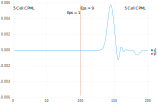

In [7]:
plot(1:size, fieldsnap)
plot!([100, 100], [-maximum(abs(fieldsnap)), maximum(abs(fieldsnap))])
plot!(ann=[(80, 0.8*maximum(abs(fieldsnap)), "Eps = 1")])
plot!(ann=[(100, 0.9*maximum(abs(fieldsnap)), "Eps = 9")])
plot!(ann=[(0, 0.9*maximum(abs(fieldsnap)), "5 Cell CPML")])
plot!(ann=[(165, 0.9*maximum(abs(fieldsnap)), "5 Cell CPML")])

In [8]:
print(fieldsum)

0.00027295405799045684

# 2. Dielectric eps=9 with 10 Cell CPML, Pulse width = 400
### Setup Grid

In [9]:
#Global parameters
size = 200;
endTime = 1000;
num_snaps = 200;
snap_step = div(endTime, num_snaps);

eps1 = 9;
eps0 = 1;

#Grid

# Magnetic
hy = zeros(size);
mu = ones(size);

chyh = ones(size);
chye = ones(size);

# Electric
ez = zeros(size);
eps = ones(size);

cezh = ones(size);
ceze = ones(size);


for i in 1:99
    eps[i] = eps0;
end
for i in 100:size
    eps[i] = eps1;
end

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

# 
fieldsum = 1;
sumtime = 900;
fieldsnap = zeros(size);


### Setup CPML

In [10]:
#
# setup CPML
#

# constants
dx = 1.0;
R0 = 1e-5;
m = 2.85;
pml_width = 10.0;

# coeffs
sigma_max = -(m+1)*log(R0)/2/globals.imp0/(pml_width*dx)
sigma_x = zeros(size);
sigma_m_x = zeros(size);

for i in 1:round(Int,pml_width)
    sigma_x[i+1] = sigma_max * real(Complex(((pml_width-(i-1)-0.5)/pml_width))^m)
    sigma_m_x[i] = sigma_max * real(Complex(((pml_width-(i-1))/pml_width))^m)
    
    sigma_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-(i)-0.5)/pml_width))^m)  
    sigma_m_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-(i))/pml_width))^m)
end

aex = exp(-sigma_x .* globals.imp0)-1
bex = exp(-sigma_x .* globals.imp0)

ahx = exp(-sigma_m_x .* globals.imp0)-1
bhx = exp(-sigma_m_x .* globals.imp0)

# arrays
p_hy = zeros(size);
p_ez = zeros(size);

### Run Simulation

In [11]:
for time in 1:endTime
    # Incident
    # ez_inc, hy_inc = sources.gaussian_source(50, time);
    delay = 400.
    width = 400.
    
    ez_inc = exp(-(time + 0.5 - (-0.5) - delay) * (time + 0.5 - (-0.5) - delay) / width);
    hy_inc = exp(-(time - delay) * (time - delay) / width);


    #
    # Magnetic
    #

    # CPML
    for i in 1:size-1
        p_hy[i] = bhx[i]*p_hy[i] + ahx[i]*(ez[i+1] - ez[i])
    end
           
    # Interior update
    for i = 1:size-1
        hy[i] = chyh[i] * hy[i] + chye[i] * (ez[i+1] - ez[i]) / globals.imp0 / mu[i]
    end
       
    # CPML
    for i in 1:size-1
        hy[i] += p_hy[i]/globals.imp0/mu[i]
    end

    # TFSF
    hy[49] -= hy_inc / globals.imp0 / mu[49]
    
    #
    # Electric
    #
    
    # CPML
    for i in 2:size
        p_ez[i] = bex[i]*p_ez[i] + aex[i]*(hy[i] - hy[i-1])
    end

    # Interior update
    for i = 2:size
        ez[i] = ceze[i] * ez[i] + cezh[i] * (hy[i] - hy[i-1]) * globals.imp0 / eps[i]
    end  
 
    # CPML
    for i in 2:size
        ez[i] += p_ez[i]*globals.imp0/eps[i]
    end
    # TFSF
    ez[50] += ez_inc / eps[50]


    #Catch minimum E-Field
    if time == sumtime
            fieldsum = sum(ez.^2)
            fieldsnap = copy(ez)
    end
    
    #Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end
print(fieldsum)

9.117804315480013e-7

### Plot animation

In [12]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(150, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "CPML")])
    
    plot!(ann=[(80, 1.2, "Eps = 1")])
    plot!(ann=[(101, 1.1, "Eps = 9")])    
    plot!([100, 100], [-2, 2])
    
    plot!(ann=[(180, 1.1, "CPML")])
    
    plot!(xlims=(1, 200), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task1/CPML_Pulse_400.gif", fps=15)

INFO: Saved animation to /media/storage/Documents/Github/1d-fdtd/tasks/Task1/CPML_Pulse_400.gif


Plots.AnimatedGif("/media/storage/Documents/Github/1d-fdtd/tasks/Task1/CPML_Pulse_400.gif")

### Field after reflection

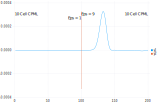

In [13]:
plot(1:size, fieldsnap)
plot!([100, 100], [-maximum(abs(fieldsnap)), maximum(abs(fieldsnap))])
plot!(ann=[(80, 0.8*maximum(abs(fieldsnap)), "Eps = 1")])
plot!(ann=[(100, 0.9*maximum(abs(fieldsnap)), "Eps = 9")])
plot!(ann=[(0, 0.9*maximum(abs(fieldsnap)), "10 Cell CPML")])
plot!(ann=[(165, 0.9*maximum(abs(fieldsnap)), "10 Cell CPML")])

In [14]:
print(fieldsum)

9.117804315480013e-7